In [1]:
#| default_exp models.rnn

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

#  RNN

Elman proposed this classic recurrent neural network (`RNN`) in 1990, where each layer uses the following recurrent transformation:
$$\mathbf{h}^{l}_{t} = \mathrm{Activation}([\mathbf{y}_{t},\mathbf{x}^{(h)}_{t},\mathbf{x}^{(s)}] W^{\intercal}_{ih} + b_{ih}  +  \mathbf{h}^{l}_{t-1} W^{\intercal}_{hh} + b_{hh})$$ 

where $\mathbf{h}^{l}_{t}$, is the hidden state of RNN layer $l$ for time $t$, $\mathbf{y}_{t}$ is the input at time $t$ and $\mathbf{h}_{t-1}$ is the hidden state of the previous layer at $t-1$, $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(h)}_{t}$ historic exogenous, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction. The available activations are `tanh`, and `relu`. The predictions are obtained by transforming the hidden states into contexts $\mathbf{c}_{[t+1:t+H]}$, that are decoded and adapted into $\mathbf{\hat{y}}_{[t+1:t+H],[q]}$ through MLPs.

\begin{align}
 \mathbf{h}_{t} &= \textrm{RNN}([\mathbf{y}_{t},\mathbf{x}^{(h)}_{t},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\\
\mathbf{c}_{[t+1:t+H]}&=\textrm{Linear}([\mathbf{h}_{t}, \mathbf{x}^{(f)}_{[:t+H]}]) \\ 
\hat{y}_{\tau,[q]}&=\textrm{MLP}([\mathbf{c}_{\tau},\mathbf{x}^{(f)}_{\tau}])
\end{align}

**References**<br>
-[Jeffrey L. Elman (1990). "Finding Structure in Time".](https://onlinelibrary.wiley.com/doiabs/10.1207/s15516709cog1402_1)<br>
-[Cho, K., van Merrienboer, B., Gülcehre, C., Bougares, F., Schwenk, H., & Bengio, Y. (2014). Learning phrase representations using RNN encoder-decoder for statistical machine translation.](http://arxiv.org/abs/1406.1078)<br>

![Figure 1. Single Layer Elman RNN with MLP decoder.](imgs_models/rnn.png)

In [3]:
#| hide
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#| export
from typing import Optional

import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_recurrent import BaseRecurrent
from neuralforecast.common._modules import MLP
from neuralforecast.common._modules import Concentrator

In [5]:
#| export
class RNN(BaseRecurrent):
    """ RNN

    Multi Layer Elman RNN (RNN), with MLP decoder.
    The network has `tanh` or `relu` non-linearities, it is trained using 
    ADAM stochastic gradient descent. The network accepts static, historic 
    and future exogenous data.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
    `encoder_n_layers`: int=2, number of layers for the RNN.<br>
    `encoder_hidden_size`: int=200, units for the RNN's hidden state size.<br>
    `encoder_activation`: str=`tanh`, type of RNN activation from `tanh` or `relu`.<br>
    `encoder_bias`: bool=True, whether or not to use biases b_ih, b_hh within RNN units.<br>
    `encoder_dropout`: float=0., dropout regularization applied to RNN outputs.<br>
    `context_size`: int=10, size of context vector for each timestamp on the forecasting window.<br>
    `decoder_hidden_size`: int=200, size of hidden layer for the MLP decoder.<br>
    `decoder_layers`: int=2, number of layers for the MLP decoder.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of differentseries in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    
    """
    def __init__(self,
                 h: int,
                 input_size: int = -1,
                 encoder_n_layers: int = 2,
                 encoder_hidden_size: int = 200,
                 encoder_activation: str = 'tanh',
                 encoder_bias: bool = True,
                 encoder_dropout: float = 0.,
                 context_size: int = 10,
                 decoder_hidden_size: int = 200,
                 decoder_layers: int = 2,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size=32,
                 valid_batch_size: Optional[int] = None,
                 scaler_type: str='robust',
                 random_seed=1,
                 num_workers_loader=0,
                 drop_last_loader=False,
                 # New parameters
                 use_concentrator: bool = False,
                 concentrator_type: str = None,
                 n_series: int = 1,
                 treatment_var_name: str = "treatment",
                 freq: int=1,
                 **trainer_kwargs,
                 ):
        super(RNN, self).__init__(
            h=h,
            input_size=input_size,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            scaler_type=scaler_type,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            num_workers_loader=num_workers_loader,
            drop_last_loader=drop_last_loader,
            random_seed=random_seed,
            **trainer_kwargs
        )

        # ------------------ Concentrator ------------------
        # Asserts
        if use_concentrator:
            assert (
                treatment_var_name in hist_exog_list
            ), f"Variable {treatment_var_name} not found in hist_exog_list!"
            assert (
                hist_exog_list[-1] == treatment_var_name
            ), f"Variable {treatment_var_name} must be the last element of hist_exog_list!"

        self.use_concentrator = use_concentrator

        if self.use_concentrator:
            self.concentrator = Concentrator(
                n_series=n_series,
                type=concentrator_type,
                treatment_var_name=treatment_var_name,
                input_size=input_size,
                freq=freq,
            )
        else:
            self.concentrator = None
        # --------------------------------------------------

        # RNN
        self.encoder_n_layers = encoder_n_layers
        self.encoder_hidden_size = encoder_hidden_size
        self.encoder_activation = encoder_activation
        self.encoder_bias = encoder_bias
        self.encoder_dropout = encoder_dropout
        
        # Context adapter
        self.context_size = context_size

        # MLP decoder
        self.decoder_hidden_size = decoder_hidden_size
        self.decoder_layers = decoder_layers

        self.futr_exog_size = len(self.futr_exog_list)
        self.hist_exog_size = len(self.hist_exog_list)
        self.stat_exog_size = len(self.stat_exog_list)
        
        # RNN input size (1 for target variable y)
        input_encoder = 1 + self.hist_exog_size + self.stat_exog_size

        # Instantiate model
        self.hist_encoder = nn.RNN(input_size=input_encoder,
                                   hidden_size=self.encoder_hidden_size,
                                   num_layers=self.encoder_n_layers,
                                   nonlinearity=self.encoder_activation,
                                   bias=self.encoder_bias,
                                   dropout=self.encoder_dropout,
                                   batch_first=True)

        # Context adapter
        self.context_adapter = nn.Linear(in_features=self.encoder_hidden_size + self.futr_exog_size * h,
                                         out_features=self.context_size * h)

        # Decoder MLP
        self.mlp_decoder = MLP(in_features=self.context_size + self.futr_exog_size,
                               out_features=self.loss.outputsize_multiplier,
                               hidden_size=self.decoder_hidden_size,
                               num_layers=self.decoder_layers,
                               activation='ReLU',
                               dropout=0.0)

    def forward(self, windows_batch):
        
        # Parse windows_batch
        encoder_input = windows_batch['insample_y'] # [B, seq_len, 1]
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']
        batch_idx     = windows_batch['batch_idx']

        # Concatenate y, historic and static inputs
        # [B, C, seq_len, 1] -> [B, seq_len, C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | S ]
        batch_size, seq_len = encoder_input.shape[:2]
        if self.hist_exog_size > 0:
            hist_exog = hist_exog.permute(0,2,1,3).squeeze(-1) # [B, X, seq_len, 1] -> [B, seq_len, X]
            if self.use_concentrator:
                hist_exog = self.concentrator(hist_exog=hist_exog,
                                    stat_exog=stat_exog,
                                    idx=batch_idx)
            encoder_input = torch.cat((encoder_input, hist_exog), dim=2)

        if self.stat_exog_size > 0:
            stat_exog = stat_exog.unsqueeze(1).repeat(1, seq_len, 1) # [B, S] -> [B, seq_len, S]
            encoder_input = torch.cat((encoder_input, stat_exog), dim=2)

        # RNN forward
        hidden_state, _ = self.hist_encoder(encoder_input) # [B, seq_len, rnn_hidden_state]

        if self.futr_exog_size > 0:
            futr_exog = futr_exog.permute(0,2,3,1)[:,:,1:,:]  # [B, F, seq_len, 1+H] -> [B, seq_len, H, F]
            hidden_state = torch.cat(( hidden_state, futr_exog.reshape(batch_size, seq_len, -1)), dim=2)

        # Context adapter
        context = self.context_adapter(hidden_state)
        context = context.reshape(batch_size, seq_len, self.h, self.context_size)

        # Residual connection with futr_exog
        if self.futr_exog_size > 0:
            context = torch.cat((context, futr_exog), dim=-1)

        # Final forecast
        output = self.mlp_decoder(context)
        output = self.loss.domain_map(output)
        
        return output

In [6]:
show_doc(RNN)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/rnn.py#L17){target="_blank" style="float:right; font-size:smaller"}

### RNN

>      RNN (h:int, input_size:int=-1, encoder_n_layers:int=2,
>           encoder_hidden_size:int=200, encoder_activation:str='tanh',
>           encoder_bias:bool=True, encoder_dropout:float=0.0,
>           context_size:int=10, decoder_hidden_size:int=200,
>           decoder_layers:int=2, futr_exog_list=None, hist_exog_list=None,
>           stat_exog_list=None, loss=MAE(), valid_loss=None,
>           max_steps:int=1000, learning_rate:float=0.001, num_lr_decays:int=-1,
>           early_stop_patience_steps:int=-1, val_check_steps:int=100,
>           batch_size=32, valid_batch_size:Optional[int]=None,
>           scaler_type:str='robust', random_seed=1, num_workers_loader=0,
>           drop_last_loader=False, use_concentrator:bool=False,
>           concentrator_type:str=None, n_series:int=1,
>           treatment_var_name:str='treatment', freq:int=1, **trainer_kwargs)

RNN

Multi Layer Elman RNN (RNN), with MLP decoder.
The network has `tanh` or `relu` non-linearities, it is trained using 
ADAM stochastic gradient descent. The network accepts static, historic 
and future exogenous data.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
`encoder_n_layers`: int=2, number of layers for the RNN.<br>
`encoder_hidden_size`: int=200, units for the RNN's hidden state size.<br>
`encoder_activation`: str=`tanh`, type of RNN activation from `tanh` or `relu`.<br>
`encoder_bias`: bool=True, whether or not to use biases b_ih, b_hh within RNN units.<br>
`encoder_dropout`: float=0., dropout regularization applied to RNN outputs.<br>
`context_size`: int=10, size of context vector for each timestamp on the forecasting window.<br>
`decoder_hidden_size`: int=200, size of hidden layer for the MLP decoder.<br>
`decoder_layers`: int=2, number of layers for the MLP decoder.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of differentseries in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
`scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h | int |  |  |
| input_size | int | -1 |  |
| encoder_n_layers | int | 2 |  |
| encoder_hidden_size | int | 200 |  |
| encoder_activation | str | tanh |  |
| encoder_bias | bool | True |  |
| encoder_dropout | float | 0.0 |  |
| context_size | int | 10 |  |
| decoder_hidden_size | int | 200 |  |
| decoder_layers | int | 2 |  |
| futr_exog_list | NoneType | None |  |
| hist_exog_list | NoneType | None |  |
| stat_exog_list | NoneType | None |  |
| loss | MAE | MAE() |  |
| valid_loss | NoneType | None |  |
| max_steps | int | 1000 |  |
| learning_rate | float | 0.001 |  |
| num_lr_decays | int | -1 |  |
| early_stop_patience_steps | int | -1 |  |
| val_check_steps | int | 100 |  |
| batch_size | int | 32 |  |
| valid_batch_size | Optional | None |  |
| scaler_type | str | robust |  |
| random_seed | int | 1 |  |
| num_workers_loader | int | 0 |  |
| drop_last_loader | bool | False |  |
| use_concentrator | bool | False | New parameters |
| concentrator_type | str | None |  |
| n_series | int | 1 |  |
| treatment_var_name | str | treatment |  |
| freq | int | 1 |  |
| trainer_kwargs |  |  |  |

In [7]:
show_doc(RNN.fit, name='RNN.fit')

---

### RNN.fit

>      RNN.fit (dataset, val_size=0, test_size=0)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [8]:
show_doc(RNN.predict, name='RNN.predict')

---

### RNN.predict

>      RNN.predict (dataset, step_size=1, **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Concentrator

In [9]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic


Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

# TREATMENT
Y_train_df['treatment'] = 0
Y_test_df['treatment'] = 0

Y_train_df['treatment'].iloc[50] = 1
Y_train_df['treatment'].iloc[100] = 1
Y_train_df['treatment'].iloc[220] = 1

Y_train_df.head()

,unique_id,ds,y,trend,y_[lag12],treatment
0,Airline1,1949-01-31,112.0,0,112.0,0
1,Airline1,1949-02-28,118.0,1,118.0,0
2,Airline1,1949-03-31,132.0,2,132.0,0
3,Airline1,1949-04-30,129.0,3,129.0,0
4,Airline1,1949-05-31,121.0,4,121.0,0


In [10]:
#| eval: false
fcst = NeuralForecast(
    models=[RNN(h=12,
                 input_size=100,
                 scaler_type='robust',
                 encoder_n_layers=2,
                 encoder_hidden_size=128,
                 context_size=10,
                 decoder_hidden_size=128,
                 decoder_layers=2,
                 max_steps=200,
                 # RELEVANT FOR TREATMENT:
                 stat_exog_list=['airline1'],
                 hist_exog_list=['trend','treatment'],
                 use_concentrator=True,
                 batch_size=2,
                 n_series=2,
                 concentrator_type='subcutaneous_injection',
                 treatment_var_name='treatment',
                 freq = 5)
    ],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=Y_test_df)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.43it/s]


[]

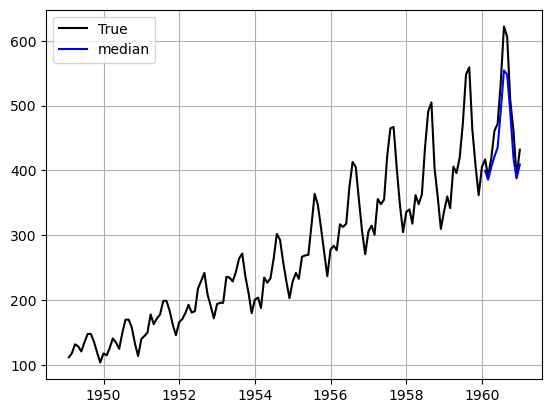

In [11]:
#| eval: false
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['RNN'], c='blue', label='median')
plt.legend()
plt.grid()
plt.plot()

In [12]:
#| eval: false
fcst.models[0].concentrator.k_a.weight

Parameter containing:
tensor([[0.5002],
        [0.6089]], requires_grad=True)